# Testing with Concept Activation Vectors (TCAV) - A step by step tutorial

Testing with Concept Activation Vectors (TCAV) is a concept-based interpretability method introduced by [Kim et al. (2018)](https://arxiv.org/pdf/1711.11279.pdf).

- {what does this method tell us?}

- {example of zebras}

## 1) Define the concepts of interest

In TCAV, a concept is defined by a set of manually selected example images that contain it. There is no restriction as to how these images should be. In the case of stripes, for example, they can be simple pictures of the texture, or pictures containing objects with stripes on, etc.

We need to:

1. Create concepts of interest defined by input images
2. Create random concepts
3. Define class of interest

In [1]:
concept = "striped"

In order to load the images we first need to define a preprocessing function:

In [2]:
from torchvision import transforms

preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Let's create a function for loading the images and applying the preprocessing transformation:

In [3]:
from pathlib import Path
from PIL import Image

import torch

def get_images_input(images_path, transform):
    imgs_files = list(Path(images_path).iterdir())
    
    prepro_imgs = []
    for file in imgs_files:
        img = Image.open(file).convert("RGB")
        img_prepro = transform(img)
        img_unsq = img_prepro.unsqueeze(0)
        prepro_imgs.append(img_unsq)
    
    imgs_tensor = torch.cat(prepro_imgs)
    
    return imgs_tensor
    

Let's load the concept images and random images:

In [5]:
concept_images = get_images_input(f"/Users/martina.gonzales/data/tcav/image/concepts/{concept}", preprocessing)
random_images = get_images_input(f"/Users/martina.gonzales/data/tcav/image/concepts/random_0", preprocessing)

print(f"Shape of concept images input: {concept_images.shape}")
print(f"Shape of random images input: {concept_images.shape}")

Shape of concept images input: torch.Size([120, 3, 224, 224])
Shape of random images input: torch.Size([120, 3, 224, 224])


In [6]:
zebra_images = get_images_input(f"/Users/martina.gonzales/data/tcav/image/imagenet/zebra", preprocessing)

## 2) compute activations

Let's define the layers:

In [7]:
layers = ["layer3"]

Let's load the model:

In [8]:
from torchvision.models import resnet50

model = resnet50(pretrained=True)
model.eval();

Let's create the hooks for the activations:

In [9]:
def get_representation(mod, inp, output):
    output = output.detach()
    features.append(output)

for layer_name, layer in model.named_modules():
    if layer_name in layers:
        handle = layer.register_forward_hook(get_representation)

Let's obtain the activations and create the feature matrix:

In [10]:
feature_matrix = []

for images_input in [concept_images, random_images]:
    features = []
    out = model(images_input)
    features = torch.cat(features)
    features = features.reshape((features.shape[0], -1))
    feature_matrix.append(features)

feature_matrix = torch.cat(feature_matrix)

Let's very the shape of the feature matrix is the expected one:

In [11]:
feature_matrix.shape

torch.Size([240, 200704])

Let's create a vector of class ids:

In [12]:
import numpy as np

class_ids = np.concatenate(
    (np.zeros(len(concept_images)), np.ones(len(random_images))),
    axis=0
)

## 3) compute Concept Activation Vectors (CAVs)

Create classifier:

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=0.01, random_state=0)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, class_ids, test_size=0.33)

clf.fit(X_train.detach().numpy(), y_train)

LogisticRegression(C=0.01, random_state=0)

Let's inspect how accurate was the classifier in distinguishing these concepts:

In [16]:
score = clf.score(X_test, y_test)
print(score)

1.0


Finally, let's create our CAV vectors, These are the weights of the model:

In [17]:
cavs = torch.tensor(np.array([-1 * clf.coef_[0], clf.coef_[0]]))

Let's inspect the shape of the CAVs:

In [18]:
cavs.shape

torch.Size([2, 200704])

## 4) compute directional derivatives

$$S_{C,\,k,\,l}\left(x\right)\,=\,\lim_{\epsilon\to 0}\frac{h_{l,k}\left(f_{l}\left(x\right)+\epsilon v_{C}^{l}\right)-h_{l,k}\left(f_{l}\left(x\right)\right)}{\epsilon}$$

> where:
>
> --> $h_{l,k}(x)$ is the logit for a data point $x$ for class $k$ (and l?)
>
> --> $f_l(x)$ is the activations for input x at layer $l$
>
> --> $v^l_C$  is a unit CAV vector for a concept C in layer $l$

$$S_{C,\,k,\,l} = \triangledown h_{l,k}(f_l(x))\cdot v^l_C$$

> the dot product of the gradient of the logit $h_{l,k}(x)$ at a point $f_l(x)$  with another tangent vector $v^l_C$  equals the directional derivative of $h_{l,k}(x)$ at $f_l(x)$ of the function along $v^l_C$

In [19]:
model = resnet50(pretrained=True)
model.eval();
# TODO: try handle.remove()

#with torch.autograd.set_grad_enabled(True):
def get_representation(mod, inp, output):
    activations.append(output)

model.layer3.register_forward_hook(get_representation)
model.fc.register_forward_hook(get_representation)

In [20]:
activations = []

out = model(zebra_images)

The variable `activations` should now be a list containing the activations for the layer of our choise, and the obtained logits for all classes:

In [21]:
print(f"Layer activations: {activations[0].shape}")
print(f"Logits: {activations[1].shape}")

Layer activations: torch.Size([86, 1024, 14, 14])
Logits: torch.Size([86, 1000])


But we only want to explore the effects on the logit corresponding to our class of interest:

In [25]:
zebra_id = 340

logits_class = activations[1][(slice(None), zebra_id)]
print(logits_class)

tensor([17.6536, 20.6904, 19.4530, 20.4575, 18.6396,  8.6665, 17.1738, 19.0760,
        11.9637, 18.3123, 14.6579, 21.5073, 23.1889, 18.8227, 15.8691, 13.1719,
        13.8625, 16.7405, 14.4536, 28.8849, 16.4080, 18.3797, 16.3117, 19.9968,
        17.7954, 19.9685, 20.7644, 12.0205, 13.3760, 17.3372, 22.7595, 20.3287,
        13.9138, 18.0066, 20.7092, 19.2362, 13.5370, 18.4035, 16.4068, 15.5538,
        15.3040, 17.4023, 15.3670, 18.0492, 17.3399, 17.8122, 22.8831, 15.4144,
        17.6903, 18.7635, 18.5754, 17.6105, 15.1015, 21.0660, 17.8932, 19.5725,
        20.8215, 17.7006, 18.1420, 15.1605, 16.8848, 21.3460, 12.9990, 18.6402,
        21.4024, 19.0466, 18.3281, 20.5895, 16.8616, 20.2436, 15.9875,  2.2596,
        15.8516, 14.2806,  6.5425, 15.7716, 16.7906, 15.4487, 17.2413, 12.2274,
        17.0387, 17.7026, 17.1721, 15.9881, 17.4786, 16.1548],
       grad_fn=<SelectBackward0>)


Let's prepare the inputs:

In [26]:
logits_class = torch.unbind(logits_class)
layer_activations = (activations[0],)

Let's now compute the gradients using the `autograd` functionality of pytorch:

In [27]:
grads = torch.autograd.grad(logits_class, layer_activations)

The result will be a torch tensor, of the same shape as the layers activations.

In [28]:
print(type(grads[0]))
print(grads[0].shape)

<class 'torch.Tensor'>
torch.Size([86, 1024, 14, 14])


We can now obtain our directional derivatives. This is computed by taking the dot product between the gradients and the concept vector:

In [31]:
# Get tensor into right format for dot product
grads_flat = (
    torch.squeeze(grads[0].reshape(grads[0].shape[0], -1))
    .type(torch.float64)
)
grads_flat.shape

dir_derivative = torch.matmul(grads_flat, cavs[0])
dir_derivative

tensor([ 0.0152,  0.0095,  0.0116,  0.0120, -0.0219,  0.1040,  0.0291,  0.0934,
         0.0554,  0.0096,  0.0199,  0.0181, -0.1213,  0.1183,  0.1115,  0.0612,
        -0.0211,  0.0466, -0.0337,  0.0208,  0.1115, -0.0303,  0.0365,  0.1749,
         0.1244, -0.0047, -0.0742,  0.1579,  0.0528,  0.0421,  0.0704, -0.0069,
         0.0754,  0.0721, -0.0234, -0.0285,  0.0119,  0.0737,  0.0128, -0.0251,
         0.0007,  0.0129,  0.0403,  0.0597,  0.0233,  0.0512,  0.0079,  0.0703,
        -0.0390, -0.0389, -0.0415, -0.0416,  0.0588,  0.0184, -0.0603, -0.0222,
         0.0463,  0.0289,  0.0085,  0.0203,  0.0522,  0.2331,  0.0073,  0.0328,
         0.1130,  0.0607,  0.0507,  0.0374, -0.0161, -0.0181, -0.0177,  0.0839,
         0.0551,  0.1101,  0.1348, -0.0279, -0.0050, -0.0144,  0.0224,  0.0258,
        -0.0404,  0.0029,  0.0062, -0.0074,  0.0549,  0.0150],
       dtype=torch.float64)

## test CAVs

$$TCAV_{Q_{C,k,l}}=\,\frac{\left|\left\{x\epsilon X_{k}:S_{C,k,l}\left(x\right)>0\right\}\right|}{\left|X_{k}\right|}$$

- scores the fraction of k-class inputs whose activation vector on layer l was positively influenced by the concept


In [32]:
tcav_score = torch.sum(dir_derivative > 0) / dir_derivative.shape[0]
print(f"TCAV score: {tcav_score}")

TCAV score: 0.7093023061752319


## Statistical testing

At least 500 times.

## Explore results

In [33]:
from torch.nn.functional import cosine_similarity

cos_sim = []
for img_idx in range(len(zebra_images)):
    img_activations = layer_activations[0][img_idx].reshape(-1).unsqueeze(dim=0)
    cos = cosine_similarity(img_activations, cavs[0].unsqueeze(dim=0))
    cos_sim.append(cos)

cos_sim = torch.tensor(cos_sim)

In [34]:
sorted_vals = torch.argsort(cos_sim)
min_vals = sorted_vals[:3]
max_vals = sorted_vals[-3:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


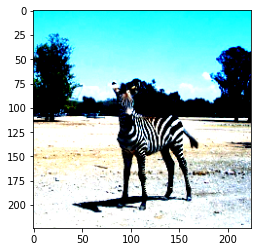

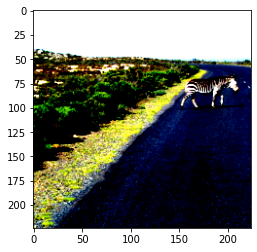

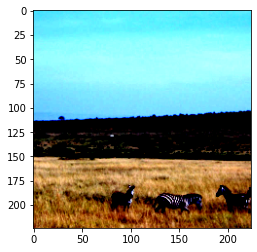

In [35]:
import matplotlib.pyplot as plt

for val in min_vals:
    plt.figure()
    plt.imshow(zebra_images[val].permute(1, 2, 0))

## Disadvantages

- Assumes linearity
- Manual annotation

-------
## Resources

- [TCAV with Captum](https://captum.ai/tutorials/TCAV_Image) tutorial.
- [Towards better understanding of gradient-based attribution methods for deep neural networks](https://arxiv.org/pdf/1711.06104.pdf) by Ancona et al. (2018), _ICLR_.